## Imports

In [18]:
from typing import Generator, Tuple

### Read

In [71]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wilat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wilat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wilat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
list(stop_words)[:4]


['each', 'in', 'so', 'hasn']

### ML

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


### Rendering

In [120]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


## Configs

In [29]:
START = "<?xml version='1.0' encoding='utf-8'?><BODY>"
END = "</BODY>"

DATADIR = "big_data_project/data"

## Reading

In [25]:
train_files = pd.read_csv("big_data_project/train.csv", names=["id", "file", "pos"], skiprows=1)

In [91]:
test_files = pd.read_csv("big_data_project/test.csv", names=["id", "file", "pos"], skiprows=1)


In [26]:
train_files.head()

,id,file,pos
0,1,1.xml,0
1,2,2.xml,0
2,3,3.xml,0
3,4,4.xml,0
4,5,5.xml,0


In [92]:
test_files.head()

,id,file,pos
0,20,20.xml,NaN
1,47,47.xml,NaN
2,57,57.xml,NaN
3,66,66.xml,NaN
4,88,88.xml,NaN


In [34]:
def get_files(files: pd.DataFrame) -> Generator[Tuple[str,str], None, None]:
    for file, pos in zip(files["file"], files["pos"]):
        with open(f"{DATADIR}/{file}", "r") as f:
            content = " ".join(f.readlines())[len(START):-len(END)]
        
        yield content, pos


In [98]:
def get_tests(files: pd.DataFrame) -> Generator[Tuple[str,str,str], None, None]:
    for fid, file in zip(files["id"], files["file"]):
        with open(f"{DATADIR}/{file}", "r") as f:
            content = " ".join(f.readlines())[len(START):-len(END)]
        
        yield fid, file, content


In [40]:
files = [e for e in get_files(train_files)]
files[1]

('Standard Oil Co and BP North America\n Inc said they plan to form a venture to manage the money market\n borrowing and investment activities of both companies.\n     BP North America is a subsidiary of British Petroleum Co\n Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.\n     The venture will be called BP/Standard Financial Trading\n and will be operated by Standard Oil under the oversight of a\n joint management committee.\n \n  Reuter\n     ',
 0)

In [42]:
X = [x for x,y in files]
y = [y for x,y in files]

X = np.array(X)
y = np.array(y)


## Training

### Clean Data

In [63]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()


In [47]:
def clean_txt(txt: str) -> str:
    # Remove all the special characters
    txt = re.sub(r'\W', ' ', txt)
    
    # remove all single characters
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)
    
    # Remove single characters from the start
    txt = re.sub(r'\^[a-zA-Z]\s+', ' ', txt) 
    
    # Substituting multiple spaces with single space
    txt = re.sub(r'\s+', ' ', txt, flags=re.I)
    
    # Removing prefixed 'b'
    txt = re.sub(r'^b\s+', '', txt)
    
    # Converting to Lowercase
    txt = txt.lower()
    
    # Lemmatization
    document = txt.split()

    document = [stemmer.lemmatize(w) for w in document]
    return " ".join(document)


In [67]:
Xc = np.array([clean_txt(x) for x in X])

### Split data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.2, random_state=0)

### Train data


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer()

In [81]:
X_train = tfidfconverter.fit_transform(X_train)
X_test = tfidfconverter.transform(X_test)


In [85]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=0)

In [86]:
y_pred = classifier.predict(X_test)


In [88]:

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[752   8]
 [ 52 148]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       760
           1       0.95      0.74      0.83       200

    accuracy                           0.94       960
   macro avg       0.94      0.86      0.90       960
weighted avg       0.94      0.94      0.93       960

0.9375


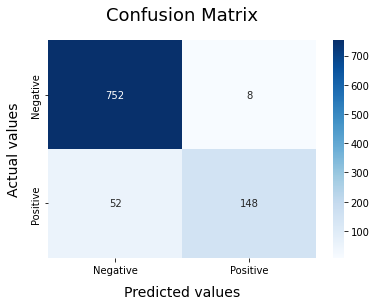

In [128]:

cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative', 'Positive']
sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.savefig("big_data_project/cmatrix.png")

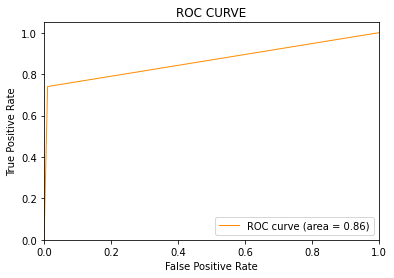

In [129]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.savefig("big_data_project/roc.png")


## Usage

In [105]:
tfiles = [e for e in get_tests(test_files)]
tfiles[1]

(47,
 '47.xml',
 'inflation\n plan, initially hailed at home and abroad as the saviour of the\n economy, is limping towards its first anniversary amid soaring\n prices, widespread shortages and a foreign payments crisis.\n     Announced last February 28 the plan froze prices, fixed the\n value of the new Cruzado currency and ended widespread\n indexation of the economy in a bid to halt the country\'s 250\n pct inflation rate.\n     But within a year the plan has all but collapsed.\n     "The situation now is worse than it was. Although there was\n inflation, at least the economy worked," a leading bank\n economist said.\n     The crumbling of the plan has been accompanied by a\n dramatic reversal in the foreign trade account. In 1984 and\n 1985 Brazil\'s annual trade surpluses had been sufficient to\n cover the 12 billion dlrs needed to service its 109 billion dlr\n foreign debt.\n     For the first nine months of 1986 all seemed to be on\n target for a repeat, with monthly surpluses a

In [110]:
end_test = [(fid, file, classifier.predict(tfidfconverter.transform([content]))[0]) for fid, file, content in tfiles]


In [113]:
end_test_df = pd.DataFrame(end_test, columns=["id","file","earnings: 0 no/ 1 yes"])


In [114]:
end_test_df.head()

,id,file,earnings: 0 no/ 1 yes
0,20,20.xml,0
1,47,47.xml,0
2,57,57.xml,0
3,66,66.xml,1
4,88,88.xml,0


In [117]:
end_test_df.to_csv("big_data_project/output.csv", index=False)
